In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

In [2]:
%run Model.ipynb

In [3]:
problems = load_problems("/Users/simonhusebo/Dokumenter/MASTERS CODE/data")
problem_types = ['16_4_4', '30_5_7','42_7_10','72_9_18','121_11_35','300_20_70']

<Axes: title={'center': 'Instance: 30'}>

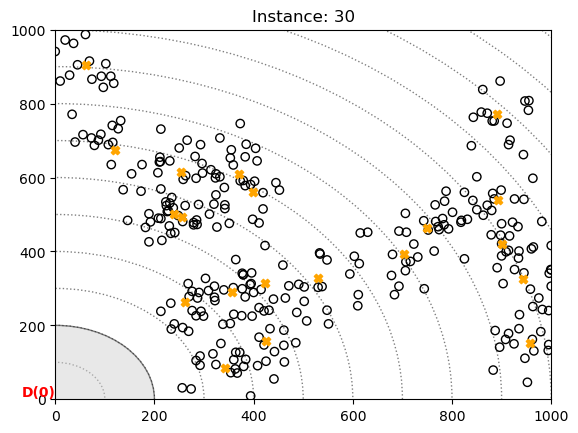

In [150]:
instance = 30
problem = problems[instance-1]
n_trips = problem['N_trips']
initial = initial_solution(problem,n_trips)
operators = [random_remove_greedy_insert,largest_trip_remove_greedy_insert,similarity_removal_greedy_insert,worst_removal_greedy_insert,smallest_trip_removal_greedy_insert,random_remove_kregret_insert,largest_trip_remove_kregret_insert,similarity_removal_kregret_insert,worst_removal_kregret_insert,smallest_trip_removal_kregret_insert,clustering_removal_kncs_greedy_insert,clustering_removal_krd_greedy_insert,clustering_removal_kncs_kregret_insert,clustering_removal_krd_kregret_insert]
weights = [1/4,1/4,1/4,1/16,1/16]
show_the_map(problem, title = instance,save_ = False, save_name = "/Users/simonhusebo/Dokumenter/MASTERS CODE/figures/instance"+str(instance)+".png")


In [5]:
def multiple_ALNS_runs(problem,operators,n_runs):
    best_solution = 0
    best_cost = float('inf')
    best_run = []
    best_run_best_costs = []
    cost_lists = []
    best_costs_lists = []
    final_improve = []
    avg_cost = []
    t0 = time.time()
    for i in range(n_runs):
        print(f'Starting run {i+1}')
        initial = initial_solution(problem,problem['N_trips'])
        _,processed_best,cost,new_best,costs,_,_,_,final_improvement,_,_, _ = ALNS(initial,problem,operators,5000)
        cost_lists.append(costs)
        best_costs_lists.append(new_best)
        final_improve.append(final_improvement)
        avg_cost.append(cost)
        if cost<best_cost:
            best_solution = processed_best
            best_cost = cost
            best_run = costs
            best_run_best_costs = new_best
            
        
    t1 = time.time()-t0
    print(f'Finished {n_runs} runs in {t1:.2f} seconds')
    avg_cost = sum(avg_cost)/n_runs
    final_improve = sum(final_improve)/n_runs
    cost_lists = [sum(values) / len(values) for values in zip(*cost_lists)]
    best_costs_lists = [sum(values) / len(values) for values in zip(*best_costs_lists)]
    
    time_per_run = t1/n_runs
    
    
    return best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run

In [6]:
def RunAll(problems,operators,n_runs):
    results = {}
    for i in range(len(problems)):
        problem = problems[i]
        print(f'Starting problem {i+1}')
        best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run = multiple_ALNS_runs(problem,operators,n_runs)
        results[i+1]=(best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run)
    return results

In [35]:
def initial_costs(problems,segment = False):
    if segment:
        idx = range(1,len(problems),5)
    else:
        idx = range(len(problems))
        
    costs = []
    for i in idx:
        problem = problems[i]
        initial = initial_solution(problem,problem['N_trips'])
        cost = objective_function(initial,problem)
        costs.append(cost)
        
    return costs

def best_cost_in_segment(results):
    costs = []
    keys = list(results.keys())
    for i in range(1,len(keys)+1,5):
        ks = keys[i:i+5]
        avg = sum([results[k][2] for k in ks])/5
        
        costs.append(avg)
        
    
    
    return costs

In [33]:
def calculate_improvement(problems, results,segment = False):
    base_costs = initial_costs(problems,segment)
    keys = list(results.keys())

    if segment:
        c = best_cost_in_segment(results)
        
    else:
        c = [results[k][2] for k in keys]
        
    improvements = []
    i=1
    for base_cost, best_cost in zip(base_costs, c):
        improvement = ((base_cost - best_cost) / base_cost) * 100
        improvements.append(improvement)
        i+=1
    return improvements


In [9]:
def ExperimentII(problem,trip_range):
    
    n_runs = 10
    
    n_charges_lists = []
    amnt_charged_lists = []
    n_vessels = [i for i in trip_range]
    vessel_count_lists = []
    best_costs = []
    best_solutions = []
    avg_costs = []
    
    for i in trip_range:
        print(f'Starting iteration with {i} Vessels')
        n_charges = []
        amnt_charged = []
        best_cost = float('inf')
        best_solution = []
        vessel_count = []
        costs = []
        for j in range(n_runs):
            print(f'Starting run {j+1}')
            initial = initial_solution(problem,n_trips=i)
            _,processed_best,new_cost,_,_,_,_,_,_,_,_, _ = ALNS(initial,problem,operators,5000)

            sol,ves,charging = processed_best
                
            charging = [x for x in charging if x != []]
            
  
            charging_count = sum(len(sublist) for sublist in charging)
            
            amnt = 0
            for v in range(len(charging)):
                trip_charge = charging[v]
                amnt += sum([trip_charge[k][1] for k in range(len(trip_charge))])
            
            ves_count = [ves.count(i) for i in range(1, 4)]
            
            n_charges.append(charging_count)
            amnt_charged.append(amnt)
            vessel_count.append(ves_count)
            costs.append(new_cost)
            
            if new_cost<best_cost:
                best_solution = processed_best
                best_cost = new_cost
            
        n_charges_lists.append(n_charges)
        amnt_charged_lists.append(amnt_charged)
        vessel_count_lists.append(vessel_count)
        best_costs.append(best_cost)
        best_solutions.append(best_solution)
        avg_costs.append(sum(costs)/n_runs)  
        
        
    return best_solutions,best_costs,avg_costs,n_charges_lists,amnt_charged_lists,vessel_count_lists,n_vessels

In [114]:

def calculate_average_vessel_usage(vessel_count_lists):
    # Get the indices of the vessel range within the n_vessels list
    
    vessel_count_array = np.array(vessel_count_lists)
    
    total_vessels_utilized = np.sum(vessel_count_array, axis=2)
    average_total_vessels_utilized = np.mean(total_vessels_utilized, axis=1)
    overall_average_total_vessels = np.mean(average_total_vessels_utilized)
    
    average_vessels_per_type = np.mean(vessel_count_array, axis=(0, 1))

    return overall_average_total_vessels, average_vessels_per_type.tolist()


In [11]:
def ExIII(problems):
    
    ######### Experiment III ########
    #DOUBLE THE RANGE OF THE VESSELS#
    
    ExIII_all_instances = RunAll(problems,operators,5)
    
    
    instance = 23
    problem = problems[instance-1]
    
    ExIII_instance23 = ExperimentII(problem,range(20,41))
    

    return ExIII_all_instances,ExIII_instance23

    

In [12]:
#exIII_all, exIII_instance23 = ExIII(problems)

In [3]:
def load_results():
    with open('/Users/simonhusebo/Dokumenter/MASTERS CODE/results/exIII_instance23.pkl', 'rb') as file:
        exIII_instance23 = pickle.load(file)
    with open('/Users/simonhusebo/Dokumenter/MASTERS CODE/results/ExIII_all.pkl', 'rb') as file:
        exIII_all = pickle.load(file)
    with open('/Users/simonhusebo/Dokumenter/MASTERS CODE/results/baseline.pkl', 'rb') as file:
        baseline = pickle.load(file)
    with open('/Users/simonhusebo/Dokumenter/MASTERS CODE/results/ExperimentII_instance23_1905.pkl', 'rb') as file:
        exII = pickle.load(file)
        
    return exIII_instance23,exIII_all,baseline,exII

In [17]:
def print_all(results):
    keys = results.keys()
    for key in keys:
        #results[i+1]=(best_solution,avg_cost,best_cost,best_run,best_run_best_costs,best_costs_lists,cost_lists,final_improve,time_per_run)
        print(f'Problem {key}')
        print(f'Average cost: {results[key][1]}')
        print(f'Best cost: {results[key][2]}')
        print(f'Final improvement: {results[key][7]}')
        print(f'Average time: {results[key][8]}')
        plot_costs(results[key][5],title=f'Problem {key} costs')
        plot_costs(results[key][3],title=f'Problem {key} best run')
        multiple_plots(results[key][4],results[key][5],title=f'Problem {key} average best costs (run) with best run (blue)')
        print('\n')

In [18]:
def latex_prints(results,problems):
    instances_per_type = 5

    improvements = calculate_improvement(problems,results)
    problem_types = ['16\_4\_4', '30\_5\_7', '42\_7\_10', '72\_9\_18', '121\_11\_35', '300\_20\_70']

    # Print formatted rows for LaTeX
    for key in sorted(results.keys()):
        # Determine problem type and instance number within type
        type_index = (key - 1) // instances_per_type
        instance_number_within_type = (key - 1) % instances_per_type + 1
        problem_label = f"{{{problem_types[type_index]}/{instance_number_within_type}}}"
        
        instance_data = results[key]
        print(f"{problem_label} & {instance_data[2]:,.0f} & {instance_data[1]:,.0f} & {improvements[key-1]:.2f}\\% & {instance_data[8]:,.0f} \\\\")

In [37]:
def double_latex_prints(results1,results2,problems):
    instances_per_type = 5

    improvements1 = calculate_improvement(problems,results1)
    improvements2 = calculate_improvement(problems,results2)
    problem_types = ['16\_4\_4', '30\_5\_7', '42\_7\_10', '72\_9\_18', '121\_11\_35', '300\_20\_70']
    
    p = []

    # Print formatted rows for LaTeX
    for key in sorted(results1.keys()):
        # Determine problem type and instance number within type
        type_index = (key - 1) // instances_per_type
        instance_number_within_type = (key - 1) % instances_per_type + 1
        problem_label = f"{{{problem_types[type_index]}/{instance_number_within_type}}}"
        improvement1 = round(improvements1[key-1],2)
        improvement2 = round(improvements2[key-1],2)
        data1 = results1[key]
        data2 = results2[key]
        
        percent = ((data1[1]-data2[1])/data1[2])*100
        p.append(percent)
        
        
        a = f"{(improvement1-improvement2):.2f}\\%"
        print(f"{problem_label} & {data1[2]:,.0f} & {data2[2]:,.0f} & {data1[1]:,.0f} & {data2[1]:,.0f} & {percent:.2f}\\% \\\\")
        
    std = np.std(p)
    print(f'Average improvement: {sum(p)/len(p):.2f}% +/- {std:.2f}%')

In [38]:
def prints_per_problem_type(results):
    avg_costs,plots,imps,best_costs,times,improvements,data = average_data(results)
    
    for k in range(6):
        print(f'Problem type: {problem_types[k]}')
        print(f'Best cost: {best_costs[k]:.0f}')
        print(f'Average cost: {avg_costs[k]:.0f}')
        print(f'Average improvement iterations: {imps[k]:.0f}')
        print(f'Average time per run: {times[k]:.0f}s')
        print(f'Improvement: {improvements[k]:.2f}%')
        plot_costs(plots[k],title=f'Problem type: {problem_types[k]}')
        zoomed_plot(plots[k],0,200)
    

In [39]:
def latex_per_problemtype(results):
    avg_costs,plots,imps,best_costs,times,improvements,data = average_data(results)
    # Assumed variables and problem_types are defined as before
    problem_types = ['16\_4\_4', '30\_5\_7', '42\_7\_10', '72\_9\_18', '121\_11\_35', '300\_20\_70']

    # Print formatted rows for LaTeX
    for index, problem_type in enumerate(problem_types):
        print(f"{problem_type} & {best_costs[index]:,.0f} & {avg_costs[index]:,.0f} & {improvements[index]:.2f}\\% &  {times[index]:,.0f} \\\\")


In [40]:
def average_data(results):
    avg_costs = []
    plots = []
    data = []
    imps = []
    best_costs = []
    times = []
    keys = list(range(1,31))

    for i in range(0,len(keys),5):
        ks = keys[i:i+5]
        costs = sum([results[k][1] for k in ks])/5
        runs = [results[k][5] for k in ks]
        a = [sum(values) / len(values) for values in zip(*runs)]
        imp_iterations = sum([results[k][7] for k in ks])/5
        best_cost = sum([results[k][2] for k in ks])/5
        t = sum([results[k][8] for k in ks])/5
        imps.append(imp_iterations)
        times.append(t)
        best_costs.append(best_cost)    
        avg_costs.append(costs)
        data.append(a)
        plots.append(a)
        
    improvements = []
        
    for idx in range(6):
        problem = problems[idx*5]
        initial = initial_solution(problem,problem['N_trips'])
        initial_cost = objective_function(initial,problem)
        improvements.append((initial_cost-best_costs[idx])/initial_cost*100)
        
    
    return avg_costs,plots,imps,best_costs,times,improvements,data
    
    

In [30]:
def compare_results(results1, results2):
    avg_costs1, plots1, imps1, best_costs1, times1, improvements1, data1 = average_data(results1)
    avg_costs2, plots2, imps2, best_costs2, times2, improvements2, data2 = average_data(results2)
    
    for k in range(6):
        print(f'Problem type: {problem_types[k]} \n\t\t\tBaseline\t| ExIII')
        print(f'Best cost:\t\t\t{best_costs1[k]:>7.0f}\t| {best_costs2[k]:<7.0f}')
        print(f'Average cost:\t\t\t{avg_costs1[k]:>7.0f}\t| {avg_costs2[k]:<7.0f}')
        print(f'Average improvement iterations:\t{imps1[k]:>7.0f}\t| {imps2[k]:<7.0f}')
        print(f'Average time per run:\t\t{times1[k]:>7.0f}s\t| {times2[k]:<7.0f}s')
        print(f'Improvement:\t\t\t{improvements1[k]:>6.2f}%\t| {improvements2[k]:<6.2f}%')
        
        zoomed_plot(data1[k], 0, 500, data2=data2[k])


In [89]:
def calculate_and_print_regression(n_vessels, data_lists, label):
    df, avgs = data_prep(n_vessels, data_lists)
    coeffs = np.polyfit(n_vessels, avgs, 1)
    poly = np.poly1d(coeffs)
    print(f'Regression function for {label}: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}')
    
    return coeffs
